In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## LSTM & GRU

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import os

### --- 1. Load và chuẩn bị dữ liệu ---

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/train_data.csv')

# Đảm bảo cột comment sạch không bị NaN
df['comment_clean_stage2'] = df['comment_clean_stage2'].fillna('').astype(str)

# Tạo nhãn đa nhãn
labels = df[['positive', 'negative']].values
comments = df['comment_clean_stage2'].values

### --- 2. Tokenization và Padding ---

In [ ]:
MAX_NUM_WORDS = 10000  # Giới hạn số lượng từ trong từ điển
MAX_SEQUENCE_LENGTH = 150 # Độ dài tối đa của một chuỗi (comment)
EMBEDDING_DIM = 300    # Kích thước vector embedding

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

data_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Found 2354 unique tokens.


### --- 3. Chia dữ liệu ---

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(data_padded, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Val labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (1596, 150), Train labels shape: (1596, 2)
Validation data shape: (342, 150), Val labels shape: (342, 2)
Test data shape: (342, 150), Test labels shape: (342, 2)


### --- 4. Định nghĩa các mô hình ---

In [ ]:
def build_bilstm_model(vocab_size, embedding_dim, max_length, num_labels=2):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)), # Giữ lại chuỗi cho lớp tiếp theo hoặc pooling
        # GlobalMaxPooling1D(), # Có thể thêm pooling nếu muốn
        Bidirectional(LSTM(32)), # Lớp LSTM cuối không cần return_sequences=True
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_labels, activation='sigmoid') # Sigmoid cho multi-label
    ])
    model.compile(loss='binary_crossentropy', # Phù hợp cho multi-label
                  optimizer='adam',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]) # AUC là metric tốt
    return model

def build_bigru_model(vocab_size, embedding_dim, max_length, num_labels=2):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length),
        Bidirectional(GRU(64, return_sequences=True)),
        # GlobalMaxPooling1D(),
        Bidirectional(GRU(32)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_labels, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

### --- 5. Huấn luyện và Đánh giá ---

In [ ]:
models_to_train = {
    "BiLSTM": build_bilstm_model(MAX_NUM_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH),
    "BiGRU": build_bigru_model(MAX_NUM_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
}

results = {}
histories = {}
training_times = {}
prediction_times = {}

BATCH_SIZE = 32 # Giảm nếu gặp lỗi OOM (Out of Memory)
EPOCHS = 50     # Số epochs lớn, dùng EarlyStopping để dừng sớm

# Tạo thư mục lưu model weights
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

for model_name, model in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    model.summary()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        filepath=f'model_checkpoints/{model_name}_best.keras', # Sử dụng định dạng .keras mới
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )

    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=2) # verbose=2 cho ít output hơn
    end_time = time.time()
    training_times[model_name] = end_time - start_time
    histories[model_name] = history

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    # Load lại best model đã lưu
    best_model = tf.keras.models.load_model(f'model_checkpoints/{model_name}_best.keras')

    loss, binary_acc, auc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_name} Test Loss: {loss:.4f}")
    print(f"{model_name} Test Binary Accuracy: {binary_acc:.4f}")
    print(f"{model_name} Test AUC: {auc:.4f}")

    # Dự đoán và tính toán các metrics khác
    start_pred_time = time.time()
    y_pred_prob = best_model.predict(X_test)
    end_pred_time = time.time()
    prediction_times[model_name] = end_pred_time - start_pred_time

    y_pred = (y_pred_prob > 0.5).astype(int) # Ngưỡng 0.5 để chuyển prob -> class

    # Metrics chi tiết (Sklearn)
    accuracy = accuracy_score(y_test, y_pred) # Subset accuracy
    hamming = hamming_loss(y_test, y_pred)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_samples = f1_score(y_test, y_pred, average='samples')
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"\n{model_name} Detailed Test Metrics:")
    print(f"  Subset Accuracy (Exact Match Ratio): {accuracy:.4f}")
    print(f"  Hamming Loss (Lower is better): {hamming:.4f}")
    print(f"  F1 Score (Micro): {f1_micro:.4f}")
    print(f"  F1 Score (Macro): {f1_macro:.4f}")
    print(f"  F1 Score (Samples): {f1_samples:.4f}") # Trung bình F1 của từng mẫu
    print(f"  Precision (Macro): {precision_macro:.4f}")
    print(f"  Recall (Macro): {recall_macro:.4f}")
    print("\nClassification Report (Label-wise):")
    print(classification_report(y_test, y_pred, target_names=['positive', 'negative'], zero_division=0))

    results[model_name] = {
        'loss': loss,
        'binary_accuracy': binary_acc,
        'auc': auc,
        'subset_accuracy': accuracy,
        'hamming_loss': hamming,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_samples': f1_samples,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'training_time': training_times[model_name],
        'prediction_time_per_batch': prediction_times[model_name] / len(X_test) if len(X_test)>0 else 0
    }


--- Training BiLSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 7s - 133ms/step - auc: 0.7516 - binary_accuracy: 0.6711 - loss: 0.5967 - val_auc: 0.9187 - val_binary_accuracy: 0.8392 - val_loss: 0.4119
Epoch 2/50
50/50 - 2s - 36ms/step - auc: 0.9122 - binary_accuracy: 0.8694 - loss: 0.3731 - val_auc: 0.9243 - val_binary_accuracy: 0.8553 - val_loss: 0.3596
Epoch 3/50
50/50 - 2s - 41ms/step - auc: 0.9565 - binary_accuracy: 0.9110 - loss: 0.2603 - val_auc: 0.9395 - val_binary_accuracy: 0.8743 - val_loss: 0.3189
Epoch 4/50
50/50 - 3s - 60ms/step - auc: 0.9709 - binary_accuracy: 0.9292 - loss: 0.2084 - val_auc: 0.9362 - val_binary_accuracy: 0.8757 - val_loss: 0.3313
Epoch 5/50
50/50 - 2s - 37ms/step - auc: 0.9843 - binary_accuracy: 0.9521 - loss: 0.1514 - val_auc: 0.9396 - val_binary_accuracy: 0.8655 - val_loss: 0.3599
Epoch 6/50
50/50 - 2s - 42ms/step - auc: 0.9880 - binary_accuracy: 0.9637 - loss: 0.1260 - val_auc: 0.9369 - val_binary_accuracy: 0.8670 - val_loss: 0.4018
Epoch 7/50
50/50 - 1s - 28ms/step - auc: 0.9868 - binary_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 6s - 125ms/step - auc: 0.7903 - binary_accuracy: 0.6992 - loss: 0.5478 - val_auc: 0.8997 - val_binary_accuracy: 0.8348 - val_loss: 0.3913
Epoch 2/50
50/50 - 2s - 42ms/step - auc: 0.9276 - binary_accuracy: 0.8684 - loss: 0.3415 - val_auc: 0.9251 - val_binary_accuracy: 0.8523 - val_loss: 0.3491
Epoch 3/50
50/50 - 2s - 31ms/step - auc: 0.9590 - binary_accuracy: 0.9066 - loss: 0.2546 - val_auc: 0.9369 - val_binary_accuracy: 0.8670 - val_loss: 0.3274
Epoch 4/50
50/50 - 3s - 62ms/step - auc: 0.9770 - binary_accuracy: 0.9370 - loss: 0.1864 - val_auc: 0.9475 - val_binary_accuracy: 0.8860 - val_loss: 0.3086
Epoch 5/50
50/50 - 1s - 27ms/step - auc: 0.9851 - binary_accuracy: 0.9474 - loss: 0.1480 - val_auc: 0.9357 - val_binary_accuracy: 0.8699 - val_loss: 0.3821
Epoch 6/50
50/50 - 3s - 51ms/step - auc: 0.9886 - binary_accuracy: 0.9637 - loss: 0.1240 - val_auc: 0.9392 - val_binary_accuracy: 0.8874 - val_loss: 0.3806
Epoch 7/50
50/50 - 1s - 27ms/step - auc: 0.9917 - binary_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### --- 6. So sánh và Vẽ biểu đồ ---


--- Comparison Summary ---
            loss  binary_accuracy       auc  subset_accuracy  hamming_loss  \
BiLSTM  0.279683         0.891813  0.954361         0.830409      0.108187   
BiGRU   0.283403         0.888889  0.957023         0.824561      0.111111   

        f1_micro  f1_macro  f1_samples  precision_macro  recall_macro  \
BiLSTM  0.887538  0.888053    0.845029         0.865433      0.912222   
BiGRU   0.883077  0.883524    0.827485         0.869669      0.898135   

        training_time  prediction_time_per_batch  
BiLSTM      21.543930                   0.003895  
BiGRU       21.139988                   0.003827  


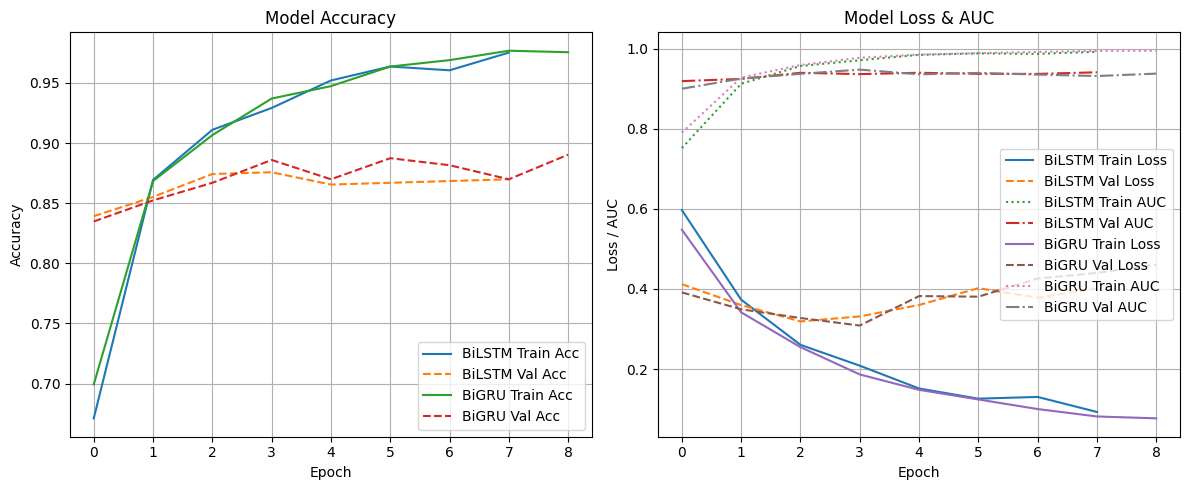

In [ ]:
print("\n--- Comparison Summary ---")
results_df = pd.DataFrame(results).T # Transpose để model thành hàng
print(results_df)

# Vẽ biểu đồ lịch sử huấn luyện (loss và accuracy)
def plot_history(histories, metric='binary_accuracy', auc_metric='auc'):
    plt.figure(figsize=(12, 5))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} Train Acc')
        plt.plot(history.history[f'val_{metric}'], label=f'{model_name} Val Acc', linestyle='--')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
        # Optional: Plot AUC if available
        if auc_metric in history.history:
            plt.plot(history.history[auc_metric], label=f'{model_name} Train AUC', linestyle=':')
        if f'val_{auc_metric}' in history.history:
             plt.plot(history.history[f'val_{auc_metric}'], label=f'{model_name} Val AUC', linestyle='-.')

    plt.title('Model Loss & AUC')
    plt.ylabel('Loss / AUC')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(histories)

### --- 7. Ví dụ dự đoán trên comment mới ---

In [ ]:
def predict_sentiment(text, model, tokenizer, max_length):
    # Làm sạch và chuẩn bị text giống như lúc train (giả sử đã có hàm clean_text)
    # clean_text = text # Tạm thời bỏ qua bước làm sạch phức tạp nếu không có sẵn
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    labels = (prediction > 0.5).astype(int)[0] # Lấy dự đoán cho mẫu đầu tiên (và duy nhất)
    return {"positive": labels[0], "negative": labels[1]}, prediction[0]

# Chọn model tốt nhất dựa trên validation (hoặc test) performance để dự đoán
best_model_name = results_df['f1_macro'].idxmax() # Ví dụ chọn theo F1 Macro cao nhất
print(f"\nUsing best model for prediction: {best_model_name}")
best_model = tf.keras.models.load_model(f'model_checkpoints/{best_model_name}_best.keras')

# Ví dụ
new_comment_positive = "điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm"
new_comment_negative = "máy lag quá dùng chán không tả nổi hay bị sập nguồn"
new_comment_mixed = "camera ổn nhưng pin tụt nhanh kinh khủng"
new_comment_neutral = "giao hàng đúng hẹn đóng_gói cẩn_thận" # Mô hình có thể khó đoán đúng neutral
comment1 = "thế_giới di_động cường_lực honor tám không"

for comment in [new_comment_positive, new_comment_negative, new_comment_mixed, new_comment_neutral, comment1]:
    pred_labels, pred_probs = predict_sentiment(comment, best_model, tokenizer, MAX_SEQUENCE_LENGTH)
    print(f"\nComment: '{comment}'")
    print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs[0]:.3f}, {pred_probs[1]:.3f})")
    print(f"  Predicted Labels: {pred_labels}")


Using best model for prediction: BiLSTM
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step

Comment: 'điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm'
  Predicted Probabilities (Pos, Neg): (0.979, 0.037)
  Predicted Labels: {'positive': np.int64(1), 'negative': np.int64(0)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Comment: 'máy lag quá dùng chán không tả nổi hay bị sập nguồn'
  Predicted Probabilities (Pos, Neg): (0.014, 0.937)
  Predicted Labels: {'positive': np.int64(0), 'negative': np.int64(1)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Comment: 'camera ổn nhưng pin tụt nhanh kinh khủng'
  Predicted Probabilities (Pos, Neg): (0.744, 0.291)
  Predicted Labels: {'positive': np.int64(1), 'negative': np.int64(0)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Comment: 'giao hàng đúng hẹn đóng_gói cẩn_thận'
  Predicted Probabilities (Pos, Neg): (0.109, 0.720)
  Predicted Labels: {'positive': np.int64(0), 'negative': np.int64(1)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Comment: 'thế_giới di_động cường_lực h

## PhoWord2Vec

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import os
from gensim.models import KeyedVectors # Hoặc Word2Vec nếu tải full model

In [2]:
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
pip install --upgrade --force-reinstall numpy scipy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninst

In [2]:
# --- 1. Load và chuẩn bị dữ liệu (Giữ nguyên như trước) ---
try:
    df1 = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/train_data.csv')
    df2 = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/generated_data.csv')
    df = pd.concat([df1, df2], ignore_index=True)
    print("Data loaded successfully.")
    # Thêm dòng này để đảm bảo bạn có đủ dữ liệu cho split
    if len(df) < 20: # Cần đủ dữ liệu để chia train/val/test
         raise ValueError("Not enough data to split. Need at least ~20 samples.")
except FileNotFoundError:
    print("Warning: 'comments.csv' not found. Using sample data.")
    # DataFrame mẫu (đảm bảo đủ dữ liệu)
    data = {'product_id': ['honor-x8b', 'honor-x8b', 'honor-x8b', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12', 'iphone-12'] * 3, # Nhân dữ liệu mẫu lên
            'comment': ['Đừng mua, ko có linh kiện.', 'Mua online bên này báo ngoài ip ra thì hàng ko có full box...', 'Mạng yếu hay mất sóng...', 'Mua máy lướt được 2 hôm đã lỗi loa ngoài...', 'Mới mua mà dễ nóng quá...', 'Hàng trưng bày. Sạc 4x lần...', 'Mặt kính cảm ứng cường lực nhưng ko chống sước...', 'Mai mốt mang đi bảo hành đây...', 'Mới mua được 3 tháng bây giờ phát hiện ra bức xạ...', 'Mới mua được 1 tháng thì xảy ra tình trạng tụt pin...', 'Bắt mạng rất yếu.', 'Tệ pin dại quá'] * 3,
            'comment_clean_stage1': ['đừng mua, không có linh kiện.', 'mua online bên này báo ngoài iphone ra thì hàng không có full box...', 'mạng yếu hay mất sóng...', 'mua máy lướt được hai hôm đã lỗi loa ngoài...', 'mới mua mà dễ nóng quá...', 'hàng trưng bày. sạc 4 lần...', 'mặt kính cảm ứng cường lực nhưng không chống sước...', 'mai mốt mang đi bảo hành đây...', 'mới mua được ba tháng bây giờ phát hiện ra bức xạ...', 'mới mua được một tháng thì xảy ra tình trạng tụt pin...', 'bắt mạng rất yếu.', 'tệ pin dại quá!.'] * 3,
            'comment_clean_stage2': ['đừng mua không linh_kiện', 'mua online bên báo iphone hàng không full box máy tạm ổn hơi nhẹ hơn xiaomi tuy_nhiên gọi mạng wifi 4g đứng hình suốt mà check máy vẫn gọi ổn không phải đường truyền mạng kém không thời_gian cửa_hàng giờ gọi hỏi bảo cửa_hàng bảo_hành mới mua được hai hôm giờ muốn đổi iphone 13 được đổi không hay hỗ_trợ đổi không shop máy gọi không thấy hình chập_chờn hoài dù mạng vẫn ổn_định sao', 'mạng yếu hay mất sóng đổi máy được không', 'mua máy lướt được hai hôm lỗi loa lúc bán nhân_viên không báo lỗi loa phải gửi đi bảo_hành mất thời_gian tốn tiền dán cường_lực pda', 'mới mua mà dễ nóng quá sạc nhất_là bật máy_ảnh phút nóng', 'hàng trưng_bày sạc bốn lần mà pin tụt', 'mặt kính cảm_ứng cường_lực nhưng không chống xước dùng được hai tháng màn_hình xước không chỗ trống thua màn_hình iphone', 'mai_mốt mang đi bảo_hành tự_nhiên sọc màn cho_dù không rơi', 'mới mua được tháng phát_hiện bức_xạ đổi được không', 'mới mua được tháng xảy tình_trạng tụt pin đêm tắt toàn_bộ ứng_dụng mạng bluetooth chả nổi quá tệ', 'bắt mạng rất yếu', 'tệ pin dại quá'] * 3,
            'rating': [1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1] * 3,
            # Tạo thêm dữ liệu đa dạng hơn (chỉ là ví dụ)
            'positive': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0] ,
            'negative': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1] }
    df = pd.DataFrame(data)
    print("Using sample data.")
except ValueError as ve:
     print(f"Error: {ve}")
     exit() # Thoát nếu không đủ dữ liệu


df['comment_clean_stage2'] = df['comment_clean_stage2'].fillna('').astype(str)
labels = df[['positive', 'negative']].values
comments = df['comment_clean_stage2'].values

Using sample data.


In [3]:
# --- 2. Tokenization (Giữ nguyên) ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150
# EMBEDDING_DIM sẽ được xác định bởi mô hình Word2Vec tải về

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")
data_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Found 133 unique tokens.


In [ ]:
# --- 3. Tải Word2Vec và Tạo Embedding Matrix ---
W2V_PATH = '/content/drive/MyDrive/Kì 7/NLP/project/word2vec_vi_words_100dims.txt' # <<< THAY ĐỔI ĐƯỜNG DẪN NÀY cho đúng file Word2Vec của bạn
EMBEDDING_DIM = None # Sẽ lấy từ model W2V
embedding_matrix = None

print(f"\nLoading Word2Vec model from: {W2V_PATH}...")
try:
    # Nếu bạn dùng file .bin (phổ biến từ Google/VinAI)
    word2vec_model = KeyedVectors.load_word2vec_format(W2V_PATH, binary=True, unicode_errors='ignore')

    # Nếu bạn dùng file .model (tự train bằng gensim)
    # from gensim.models import Word2Vec
    # word2vec_model = Word2Vec.load(W2V_PATH).wv

    print("Word2Vec model loaded successfully.")
    EMBEDDING_DIM = word2vec_model.vector_size
    print(f"Word2Vec embedding dimension: {EMBEDDING_DIM}")

    # Tạo embedding matrix
    num_tokens = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
    hits = 0
    misses = 0
    for word, i in word_index.items():
        if i >= num_tokens:
            continue
        try:
            embedding_vector = word2vec_model[word]
            embedding_matrix[i] = embedding_vector
            hits += 1
        except KeyError:
            # Từ không có trong W2V -> giữ nguyên là vector 0
            # Có thể thay bằng random nhỏ nếu muốn: np.random.rand(EMBEDDING_DIM) * 0.1 - 0.05
            misses += 1
    print(f"Created embedding matrix ({hits} words found, {misses} words missing)")

except FileNotFoundError:
    print(f"!!! Error: Word2Vec model file not found at '{W2V_PATH}'.")
    print("!!! Will use a trainable Embedding layer instead.")
    EMBEDDING_DIM = 128 # Đặt lại giá trị mặc định nếu không tải được W2V
except Exception as e:
    print(f"!!! Error loading Word2Vec model: {e}")
    print("!!! Will use a trainable Embedding layer instead.")
    EMBEDDING_DIM = 128 # Đặt lại giá trị mặc định


Loading Word2Vec model from: /content/drive/MyDrive/Kì 7/NLP/project/word2vec_vi_words_100dims.txt...


Streaming output truncated to the last 5000 lines.


In [ ]:
# --- 4. Chia dữ liệu (Giữ nguyên) ---
# Đảm bảo đủ dữ liệu sau khi load/tạo mẫu
if len(data_padded) < 5: # Kiểm tra lại trước khi split
    print("Error: Not enough data samples after processing to perform train/val/test split.")
    exit()

# Điều chỉnh test_size nếu dữ liệu quá ít
test_size = 0.3 if len(data_padded) > 10 else 0.1
val_size_ratio = 0.5 # 50% của temp set sẽ là validation

X_train, X_temp, y_train, y_temp = train_test_split(data_padded, labels, test_size=test_size, random_state=42, stratify=labels.sum(axis=1)) # Stratify có thể hữu ích
if len(X_temp) < 2: # Cần ít nhất 2 mẫu để chia tiếp
    print("Warning: Not enough data for validation set. Using test set as validation set.")
    X_val, X_test, y_val, y_test = X_temp, X_temp, y_temp, y_temp
else:
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size_ratio, random_state=42, stratify=y_temp.sum(axis=1))


print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Val labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (1596, 150), Train labels shape: (1596, 2)
Validation data shape: (342, 150), Val labels shape: (342, 2)
Test data shape: (342, 150), Test labels shape: (342, 2)


In [ ]:
# --- 5. Định nghĩa lại các mô hình để sử dụng Embedding Matrix ---

def build_model_with_embedding(model_type, vocab_size, embedding_dim, max_length, num_labels=2, embedding_matrix=None):
    """Hàm chung để xây dựng BiLSTM hoặc BiGRU với tùy chọn embedding matrix."""
    model = Sequential()
    if embedding_matrix is not None:
        print(f"Building {model_type} with pre-trained Word2Vec Embedding (non-trainable)")
        # Lấy kích thước từ embedding_matrix
        input_dim = embedding_matrix.shape[0]
        output_dim = embedding_matrix.shape[1]
        model.add(Embedding(input_dim=input_dim,
                            output_dim=output_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)) # QUAN TRỌNG: Đóng băng trọng số W2V
    else:
        print(f"Building {model_type} with trainable Embedding layer")
        # Sử dụng vocab_size và embedding_dim truyền vào
        model.add(Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_length,
                            trainable=True))

    rnn_layer = LSTM if model_type == 'BiLSTM' else GRU
    model.add(Bidirectional(rnn_layer(64, return_sequences=True)))
    model.add(Bidirectional(rnn_layer(32))) # Lớp RNN cuối không cần return_sequences
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
# --- 6. Huấn luyện và Đánh giá ---

# Xác định kích thước vocab và embedding dim hiệu dụng
if embedding_matrix is not None:
    effective_vocab_size = embedding_matrix.shape[0]
    effective_embedding_dim = embedding_matrix.shape[1]
else:
    effective_vocab_size = MAX_NUM_WORDS
    effective_embedding_dim = EMBEDDING_DIM # Sử dụng dim mặc định nếu W2V lỗi

models_to_train = {
    "BiLSTM_W2V": build_model_with_embedding('BiLSTM', effective_vocab_size, effective_embedding_dim, MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix),
    "BiGRU_W2V": build_model_with_embedding('BiGRU', effective_vocab_size, effective_embedding_dim, MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix)
}
# Đổi tên nếu dùng embedding thường
if embedding_matrix is None:
     models_to_train = {
        "BiLSTM_TrainableEmb": models_to_train["BiLSTM_W2V"],
        "BiGRU_TrainableEmb": models_to_train["BiGRU_W2V"]
     }


results = {}
histories = {}
training_times = {}
prediction_times = {}

BATCH_SIZE = 32
EPOCHS = 50

if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

# Kiểm tra xem có đủ dữ liệu huấn luyện không
if X_train.shape[0] == 0 or X_val.shape[0] == 0:
    print("\nError: Not enough data in training or validation set after splitting. Cannot train models.")
else:
    for model_name, model in models_to_train.items():
        print(f"\n--- Training {model_name} ---")
        model.summary()

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) # Thêm verbose
        model_checkpoint = ModelCheckpoint(
            filepath=f'model_checkpoints/{model_name}_best.keras',
            save_best_only=True,
            monitor='val_loss',
            mode='min'
        )

        start_time = time.time()
        history = model.fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping, model_checkpoint],
                            verbose=2)
        end_time = time.time()
        training_times[model_name] = end_time - start_time
        histories[model_name] = history

        print(f"\n--- Evaluating {model_name} on Test Set ---")
        # Tải lại model tốt nhất đã lưu (quan trọng vì early stopping có thể đã dừng)
        try:
            best_model = tf.keras.models.load_model(f'model_checkpoints/{model_name}_best.keras')
            loss, binary_acc, auc = best_model.evaluate(X_test, y_test, verbose=0)
            print(f"{model_name} Test Loss: {loss:.4f}")
            print(f"{model_name} Test Binary Accuracy: {binary_acc:.4f}")
            print(f"{model_name} Test AUC: {auc:.4f}")

            start_pred_time = time.time()
            y_pred_prob = best_model.predict(X_test)
            end_pred_time = time.time()
            prediction_times[model_name] = end_pred_time - start_pred_time
            y_pred = (y_pred_prob > 0.5).astype(int)

            accuracy = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            f1_micro = f1_score(y_test, y_pred, average='micro')
            f1_macro = f1_score(y_test, y_pred, average='macro')
            # Thêm zero_division=0 hoặc 1 cho f1_samples nếu có cảnh báo
            f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=0)
            precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)

            print(f"\n{model_name} Detailed Test Metrics:")
            print(f"  Subset Accuracy (Exact Match Ratio): {accuracy:.4f}")
            print(f"  Hamming Loss (Lower is better): {hamming:.4f}")
            print(f"  F1 Score (Micro): {f1_micro:.4f}")
            print(f"  F1 Score (Macro): {f1_macro:.4f}")
            print(f"  F1 Score (Samples): {f1_samples:.4f}")
            print(f"  Precision (Macro): {precision_macro:.4f}")
            print(f"  Recall (Macro): {recall_macro:.4f}")
            print("\nClassification Report (Label-wise):")
            print(classification_report(y_test, y_pred, target_names=['positive', 'negative'], zero_division=0))

            results[model_name] = {
                'loss': loss, 'binary_accuracy': binary_acc, 'auc': auc,
                'subset_accuracy': accuracy, 'hamming_loss': hamming,
                'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_samples': f1_samples,
                'precision_macro': precision_macro, 'recall_macro': recall_macro,
                'training_time': training_times.get(model_name, 0),
                'prediction_time_per_batch': prediction_times.get(model_name, 0) / len(X_test) if len(X_test) > 0 else 0
            }
        except Exception as eval_err:
             print(f"Error evaluating model {model_name}: {eval_err}")
             # Có thể gán giá trị mặc định hoặc NaN cho results[model_name]
             results[model_name] = {k: np.nan for k in ['loss', 'binary_accuracy', 'auc', 'subset_accuracy', 'hamming_loss', 'f1_micro', 'f1_macro', 'f1_samples', 'precision_macro', 'recall_macro', 'training_time', 'prediction_time_per_batch']}
             results[model_name]['training_time'] = training_times.get(model_name, 0)


Building BiLSTM with trainable Embedding layer


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Building BiGRU with trainable Embedding layer

--- Training BiLSTM_TrainableEmb ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 43s - 854ms/step - auc: 0.7599 - binary_accuracy: 0.6930 - loss: 0.5903 - val_auc: 0.9003 - val_binary_accuracy: 0.8216 - val_loss: 0.4089
Epoch 2/50
50/50 - 20s - 407ms/step - auc: 0.9168 - binary_accuracy: 0.8678 - loss: 0.3611 - val_auc: 0.9255 - val_binary_accuracy: 0.8494 - val_loss: 0.3552
Epoch 3/50
50/50 - 19s - 376ms/step - auc: 0.9575 - binary_accuracy: 0.9117 - loss: 0.2557 - val_auc: 0.9333 - val_binary_accuracy: 0.8699 - val_loss: 0.3460
Epoch 4/50
50/50 - 20s - 394ms/step - auc: 0.9733 - binary_accuracy: 0.9242 - loss: 0.2048 - val_auc: 0.9321 - val_binary_accuracy: 0.8626 - val_loss: 0.3744
Epoch 5/50
50/50 - 20s - 408ms/step - auc: 0.9817 - binary_accuracy: 0.9398 - loss: 0.1701 - val_auc: 0.9154 - val_binary_accuracy: 0.8450 - val_loss: 0.4111
Epoch 6/50
50/50 - 22s - 437ms/step - auc: 0.9804 - binary_accuracy: 0.9336 - loss: 0.1732 - val_auc: 0.9282 - val_binary_accuracy: 0.8523 - val_loss: 0.3786
Epoch 7/50
50/50 - 20s - 397ms/step - auc: 0.9875 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 43s - 864ms/step - auc: 0.7638 - binary_accuracy: 0.6798 - loss: 0.5805 - val_auc: 0.8907 - val_binary_accuracy: 0.7997 - val_loss: 0.4208
Epoch 2/50
50/50 - 20s - 409ms/step - auc: 0.9303 - binary_accuracy: 0.8694 - loss: 0.3352 - val_auc: 0.9101 - val_binary_accuracy: 0.8406 - val_loss: 0.3920
Epoch 3/50
50/50 - 22s - 433ms/step - auc: 0.9601 - binary_accuracy: 0.9085 - loss: 0.2496 - val_auc: 0.9121 - val_binary_accuracy: 0.8450 - val_loss: 0.3917
Epoch 4/50
50/50 - 41s - 826ms/step - auc: 0.9747 - binary_accuracy: 0.9242 - loss: 0.2021 - val_auc: 0.9118 - val_binary_accuracy: 0.8509 - val_loss: 0.4244
Epoch 5/50
50/50 - 41s - 821ms/step - auc: 0.9781 - binary_accuracy: 0.9279 - loss: 0.1885 - val_auc: 0.9054 - val_binary_accuracy: 0.8406 - val_loss: 0.4855
Epoch 6/50
50/50 - 40s - 794ms/step - auc: 0.9831 - binary_accuracy: 0.9355 - loss: 0.1652 - val_auc: 0.9060 - val_binary_accuracy: 0.8319 - val_loss: 0.4783
Epoch 7/50
50/50 - 21s - 415ms/step - auc: 0.9855 - 


--- Comparison Summary ---
                         loss  binary_accuracy       auc  subset_accuracy  \
BiLSTM_TrainableEmb  0.278632         0.881579  0.953457         0.824561   
BiGRU_TrainableEmb   0.283661         0.872807  0.952501         0.815789   

                     hamming_loss  f1_micro  f1_macro  f1_samples  \
BiLSTM_TrainableEmb      0.118421  0.874807  0.872812    0.820663   
BiGRU_TrainableEmb       0.127193  0.868778  0.869010    0.833333   

                     precision_macro  recall_macro  training_time  \
BiLSTM_TrainableEmb         0.871931      0.874644     183.882761   
BiGRU_TrainableEmb          0.854794      0.894412     269.011326   

                     prediction_time_per_batch  
BiLSTM_TrainableEmb                   0.015234  
BiGRU_TrainableEmb                    0.015239  


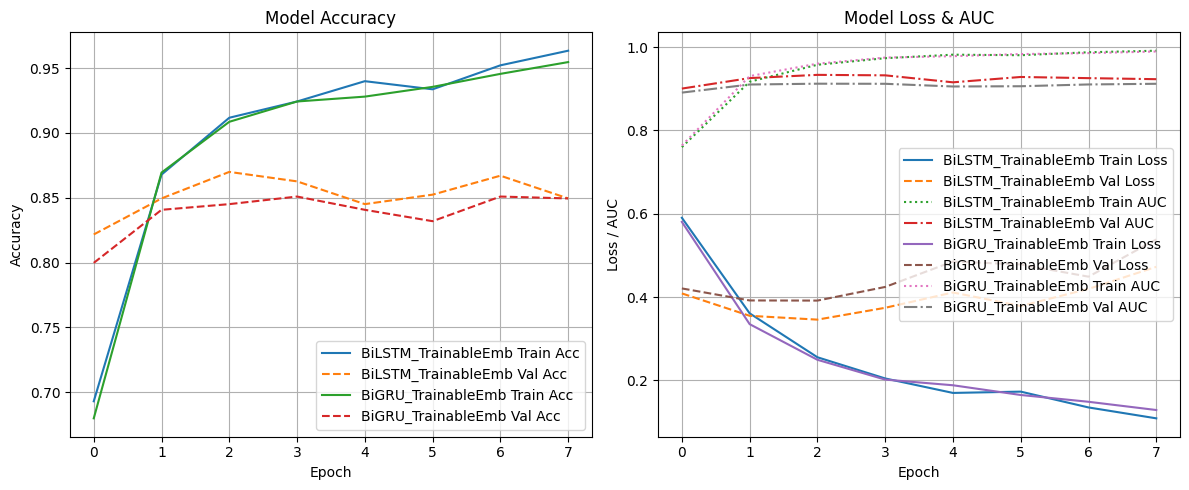

In [ ]:
# --- 7. So sánh và Vẽ biểu đồ (Giữ nguyên phần vẽ) ---
def plot_history(histories, metric='binary_accuracy', auc_metric='auc'):
    plt.figure(figsize=(12, 5))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        if metric in history.history and f'val_{metric}' in history.history:
             plt.plot(history.history[metric], label=f'{model_name} Train Acc')
             plt.plot(history.history[f'val_{metric}'], label=f'{model_name} Val Acc', linestyle='--')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Training & Validation Loss & AUC
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        if 'loss' in history.history and 'val_loss' in history.history:
             plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
             plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
        # Optional: Plot AUC if available
        if auc_metric in history.history:
            plt.plot(history.history[auc_metric], label=f'{model_name} Train AUC', linestyle=':')
        if f'val_{auc_metric}' in history.history:
             plt.plot(history.history[f'val_{auc_metric}'], label=f'{model_name} Val AUC', linestyle='-.')

    plt.title('Model Loss & AUC')
    plt.ylabel('Loss / AUC')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


if results: # Chỉ in và vẽ nếu có kết quả
    print("\n--- Comparison Summary ---")
    # Chuyển NaN thành giá trị dễ nhìn hơn nếu muốn
    results_df = pd.DataFrame(results).T.fillna('N/A')
    print(results_df)

    # Vẽ biểu đồ (kiểm tra histories trước khi vẽ)
    if histories:
        plot_history(histories) # Hàm plot_history giữ nguyên như cũ
    else:
        print("\nNo training histories to plot.")

else:
    print("\nNo models were successfully trained or evaluated.")

In [ ]:
# --- 8. Ví dụ dự đoán trên comment mới (Giữ nguyên) ---
if results: # Chỉ dự đoán nếu có model đã train và đánh giá
    try:
        # Chọn model tốt nhất dựa trên validation (hoặc test) performance để dự đoán
        # Lọc ra các model có kết quả (không phải NaN) trước khi tìm max
        valid_results_df = pd.DataFrame(results).T.dropna(subset=['f1_macro'])
        if not valid_results_df.empty:
            best_model_name = valid_results_df['f1_macro'].idxmax() # Ví dụ chọn theo F1 Macro cao nhất
            print(f"\nUsing best model for prediction: {best_model_name}")
            best_model = tf.keras.models.load_model(f'model_checkpoints/{best_model_name}_best.keras')

            # Ví dụ
            new_comment_positive = "điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm"
            new_comment_negative = "máy lag quá dùng chán không tả nổi hay bị sập nguồn"
            new_comment_mixed = "camera ổn nhưng pin tụt nhanh kinh khủng"
            new_comment_neutral = "giao hàng đúng hẹn đóng_gói cẩn_thận" # Kiểm tra lại dự đoán này
            comment1 = "thế_giới di_động có dán cường_lực honor tám không"

            for comment in [new_comment_positive, new_comment_negative, new_comment_mixed, new_comment_neutral, comment1]:
                pred_labels, pred_probs = predict_sentiment(comment, best_model, tokenizer, MAX_SEQUENCE_LENGTH) # Hàm predict_sentiment giữ nguyên
                print(f"\nComment: '{comment}'")
                print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs[0]:.3f}, {pred_probs[1]:.3f})")
                print(f"  Predicted Labels: {pred_labels}")
        else:
             print("\nCould not determine the best model as no valid results were found.")
    except Exception as pred_err:
        print(f"\nError during prediction with best model: {pred_err}")
else:
    print("\nSkipping prediction as no models were trained/evaluated successfully.")

# Hàm predict_sentiment (đã có ở code trước, copy lại nếu cần)
def predict_sentiment(text, model, tokenizer, max_length):
    # clean_text = text # Tạm thời bỏ qua làm sạch phức tạp
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence, verbose=0) # Thêm verbose=0
    labels = (prediction > 0.5).astype(int)[0]
    # Chuyển đổi kiểu dữ liệu nếu cần (ví dụ nếu đầu ra là np.int64)
    predicted_dict = {"positive": int(labels[0]), "negative": int(labels[1])}
    return predicted_dict, prediction[0]


Using best model for prediction: BiLSTM_TrainableEmb

Comment: 'điện thoại này dùng rất mượt pin trâu chụp ảnh đẹp lắm'
  Predicted Probabilities (Pos, Neg): (0.986, 0.016)
  Predicted Labels: {'positive': 1, 'negative': 0}

Comment: 'máy lag quá dùng chán không tả nổi hay bị sập nguồn'
  Predicted Probabilities (Pos, Neg): (0.019, 0.929)
  Predicted Labels: {'positive': 0, 'negative': 1}

Comment: 'camera ổn nhưng pin tụt nhanh kinh khủng'
  Predicted Probabilities (Pos, Neg): (0.088, 0.745)
  Predicted Labels: {'positive': 0, 'negative': 1}

Comment: 'giao hàng đúng hẹn đóng_gói cẩn_thận'
  Predicted Probabilities (Pos, Neg): (0.885, 0.096)
  Predicted Labels: {'positive': 1, 'negative': 0}

Comment: 'thế_giới di_động có dán cường_lực honor tám không'
  Predicted Probabilities (Pos, Neg): (0.541, 0.255)
  Predicted Labels: {'positive': 1, 'negative': 0}


## Mô hình CNN

In [ ]:
# --- Định nghĩa Mô hình CNN 1D ---
def build_cnn_model(vocab_size, embedding_dim, max_length, num_labels=2):
    """Xây dựng mô hình CNN 1D với nhiều kích thước filter."""
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=max_length)

    sequence_input = Input(shape=(max_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Sử dụng nhiều kích thước filter (n-grams)
    conv_blocks = []
    filter_sizes = [3, 4, 5] # Kích thước kernel (3-gram, 4-gram, 5-gram)
    num_filters = 128

    for filter_size in filter_sizes:
        conv = Conv1D(filters=num_filters,
                      kernel_size=filter_size,
                      padding='valid',        # 'valid' padding
                      activation='relu',
                      strides=1)(embedded_sequences)
        pool = GlobalMaxPooling1D()(conv)
        conv_blocks.append(pool)

    # Kết hợp các đặc trưng từ các filter khác nhau
    concatenated_tensor = Concatenate(axis=-1)(conv_blocks)
    dropout1 = Dropout(0.5)(concatenated_tensor)
    dense_layer = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense_layer)
    output = Dense(num_labels, activation='sigmoid')(dropout2)

    model = Model(inputs=sequence_input, outputs=output)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# --- Huấn luyện và Đánh giá Mô hình CNN ---
model_name_cnn = "CNN_1D"
model_cnn = build_cnn_model(MAX_NUM_WORDS, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

print(f"\n--- Training {model_name_cnn} ---")
model_cnn.summary()

BATCH_SIZE = 32
EPOCHS = 50 # Vẫn dùng EarlyStopping

if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')

# Callbacks
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_cnn = ModelCheckpoint(
    filepath=f'model_checkpoints/{model_name_cnn}_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

start_time_cnn = time.time()
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping_cnn, model_checkpoint_cnn],
                            verbose=2)
end_time_cnn = time.time()
training_time_cnn = end_time_cnn - start_time_cnn

print(f"\n--- Evaluating {model_name_cnn} on Test Set ---")
best_model_cnn = tf.keras.models.load_model(f'model_checkpoints/{model_name_cnn}_best.keras')

loss_cnn, binary_acc_cnn, auc_cnn = best_model_cnn.evaluate(X_test, y_test, verbose=0)
print(f"{model_name_cnn} Test Loss: {loss_cnn:.4f}")
print(f"{model_name_cnn} Test Binary Accuracy: {binary_acc_cnn:.4f}")
print(f"{model_name_cnn} Test AUC: {auc_cnn:.4f}")

start_pred_time_cnn = time.time()
y_pred_prob_cnn = best_model_cnn.predict(X_test)
end_pred_time_cnn = time.time()
prediction_time_cnn = end_pred_time_cnn - start_pred_time_cnn
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)

accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
hamming_cnn = hamming_loss(y_test, y_pred_cnn)
f1_micro_cnn = f1_score(y_test, y_pred_cnn, average='micro')
f1_macro_cnn = f1_score(y_test, y_pred_cnn, average='macro')
f1_samples_cnn = f1_score(y_test, y_pred_cnn, average='samples', zero_division=0)

print(f"\n{model_name_cnn} Detailed Test Metrics:")
print(f"  Subset Accuracy (Exact Match Ratio): {accuracy_cnn:.4f}")
print(f"  Hamming Loss (Lower is better): {hamming_cnn:.4f}")
print(f"  F1 Score (Micro): {f1_micro_cnn:.4f}")
print(f"  F1 Score (Macro): {f1_macro_cnn:.4f}")
print(f"  F1 Score (Samples): {f1_samples_cnn:.4f}")
print("\nClassification Report (Label-wise):")
print(classification_report(y_test, y_pred_cnn, target_names=['positive', 'negative'], zero_division=0))

# Lưu kết quả CNN (có thể thêm vào dict `results` nếu muốn so sánh với LSTM/GRU)
results_cnn = {
    'loss': loss_cnn,
    'binary_accuracy': binary_acc_cnn,
    'auc': auc_cnn,
    'subset_accuracy': accuracy_cnn,
    'hamming_loss': hamming_cnn,
    'f1_micro': f1_micro_cnn,
    'f1_macro': f1_macro_cnn,
    'f1_samples': f1_samples_cnn,
    'training_time': training_time_cnn,
    'prediction_time_per_batch': prediction_time_cnn / len(X_test) if len(X_test) > 0 else 0
}
print("\nCNN Results Summary:")
print(pd.Series(results_cnn))


--- Training CNN_1D ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 150, 300)  │  3,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 148, 128)  │    115,328 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 147, 128)  │    153,728 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 146, 128)  │    192,128 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     49,280 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 2)         │        258 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,510,722 (13.39 MB)

 Trainable params: 3,510,722 (13.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 - 17s - 333ms/step - auc: 0.7766 - binary_accuracy: 0.7068 - loss: 0.5761 - val_auc: 0.8863 - val_binary_accuracy: 0.8012 - val_loss: 0.4298
Epoch 2/50
50/50 - 8s - 151ms/step - auc: 0.9452 - binary_accuracy: 0.8806 - loss: 0.3015 - val_auc: 0.9428 - val_binary_accuracy: 0.8670 - val_loss: 0.3070
Epoch 3/50
50/50 - 2s - 39ms/step - auc: 0.9755 - binary_accuracy: 0.9236 - loss: 0.2005 - val_auc: 0.9504 - val_binary_accuracy: 0.8670 - val_loss: 0.2918
Epoch 4/50
50/50 - 2s - 33ms/step - auc: 0.9857 - binary_accuracy: 0.9524 - loss: 0.1457 - val_auc: 0.9519 - val_binary_accuracy: 0.8670 - val_loss: 0.2971
Epoch 5/50
50/50 - 1s - 11ms/step - auc: 0.9924 - binary_accuracy: 0.9621 - loss: 0.1107 - val_auc: 0.9539 - val_binary_accuracy: 0.8889 - val_loss: 0.3044
Epoch 6/50
50/50 - 1s - 14ms/step - auc: 0.9966 - binary_accuracy: 0.9774 - loss: 0.0686 - val_auc: 0.9474 - val_binary_accuracy: 0.8757 - val_loss: 0.3719
Epoch 7/50
50/50 - 0s - 10ms/step - auc: 0.9967 - binary_accu

In [ ]:
# --- Ví dụ dự đoán với CNN ---
def predict_sentiment_cnn(text, model, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    labels = (prediction > 0.5).astype(int)[0]
    return {"positive": labels[0], "negative": labels[1]}, prediction[0]

print("\n--- CNN Predictions ---")
new_comment_service = "giao hàng đúng hẹn đóng_gói cẩn_thận"
pred_labels_cnn, pred_probs_cnn = predict_sentiment_cnn(new_comment_service, best_model_cnn, tokenizer, MAX_SEQUENCE_LENGTH)
print(f"Comment: '{new_comment_service}'")
print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs_cnn[0]:.3f}, {pred_probs_cnn[1]:.3f})")
print(f"  Predicted Labels: {pred_labels_cnn}")

new_comment_mixed = "camera ổn nhưng pin tụt nhanh kinh khủng"
pred_labels_mixed_cnn, pred_probs_mixed_cnn = predict_sentiment_cnn(new_comment_mixed, best_model_cnn, tokenizer, MAX_SEQUENCE_LENGTH)
print(f"Comment: '{new_comment_mixed}'")
print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs_mixed_cnn[0]:.3f}, {pred_probs_mixed_cnn[1]:.3f})")
print(f"  Predicted Labels: {pred_labels_mixed_cnn}")


--- CNN Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Comment: 'giao hàng đúng hẹn đóng_gói cẩn_thận'
  Predicted Probabilities (Pos, Neg): (0.076, 0.755)
  Predicted Labels: {'positive': np.int64(0), 'negative': np.int64(1)}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Comment: 'camera ổn nhưng pin tụt nhanh kinh khủng'
  Predicted Probabilities (Pos, Neg): (0.751, 0.575)
  Predicted Labels: {'positive': np.int64(1), 'negative': np.int64(1)}


## Mô hình Transformer (PhoBERT)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Sử dụng Adam từ Keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import os

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # Kiểm tra GPU

# --- Load dữ liệu ---
try:
    # Đảm bảo đường dẫn chính xác trên Google Drive
    df = pd.read_csv('/content/drive/MyDrive/Kì 7/NLP/project/train_data.csv')
    df['comment_clean_stage2'] = df['comment_clean_stage2'].fillna('').astype(str)
    labels = df[['positive', 'negative']].values.astype(np.float32) # Đảm bảo kiểu float32
    comments = df['comment_clean_stage2'].values
    print("Data loaded.")
except FileNotFoundError:
    print("Error: '/content/drive/MyDrive/Kì 7/NLP/project/train_data.csv' not found. Please check the path.")
    exit()

# --- Thông số PhoBERT ---
MODEL_NAME = 'vinai/phobert-base'
MAX_LEN = 128

# --- Tokenization cho PhoBERT ---
tokenizer_phobert = AutoTokenizer.from_pretrained(MODEL_NAME)

# Hàm để tokenize dữ liệu (Giữ nguyên)
def phobert_encode(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_len, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='np'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
    return np.array(input_ids), np.array(attention_masks)

print("Tokenizing data for PhoBERT...")
input_ids, attention_masks = phobert_encode(comments, tokenizer_phobert, MAX_LEN)

# --- Chia dữ liệu (Giữ nguyên) ---
train_ids, temp_ids, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.3, random_state=42
)
val_ids, test_ids, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_ids, temp_masks, temp_labels, test_size=0.5, random_state=42
)
print(f"Train shapes: ids={train_ids.shape}, masks={train_masks.shape}, labels={train_labels.shape}")
print(f"Val shapes: ids={val_ids.shape}, masks={val_masks.shape}, labels={val_labels.shape}")
print(f"Test shapes: ids={test_ids.shape}, masks={test_masks.shape}, labels={test_labels.shape}")


# --- Xây dựng mô hình Fine-tuning PhoBERT ---
def build_phobert_model(model_name, max_len, num_labels=2):
    # Load pre-trained PhoBERT model
    phobert_model = TFAutoModel.from_pretrained(model_name)

    # Định nghĩa inputs
    input_ids_layer = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks_layer = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # *** SỬA ĐỔI QUAN TRỌNG Ở ĐÂY ***
    # Pass KerasTensors directly as arguments (either positionally or named)
    # Option 1: Positional arguments (if order matches expected input order)
    # outputs = phobert_model([input_ids_layer, attention_masks_layer])

    # Option 2: Named arguments (usually clearer and safer)
    outputs = phobert_model(input_ids=input_ids_layer,
                            attention_mask=attention_masks_layer)
    # *** KẾT THÚC SỬA ĐỔI ***

    # Lấy output 'pooler_output' (hoặc last_hidden_state nếu muốn)
    # pooler_output represents the [CLS] token embedding after further processing
    pooled_output = outputs.pooler_output

    # Alternative: Use last_hidden_state and potentially average or take [CLS]
    # last_hidden_state = outputs.last_hidden_state
    # Use the [CLS] token's hidden state:
    # pooled_output = last_hidden_state[:, 0, :] # Get the first token ([CLS]) embedding

    # Thêm lớp phân loại
    dropout = Dropout(0.2)(pooled_output)
    output_layer = Dense(num_labels, activation='sigmoid', name='output')(dropout)

    # Tạo model: inputs vẫn là các Input layers ban đầu
    model = Model(inputs=[input_ids_layer, attention_masks_layer], outputs=output_layer)

    # Compile với learning rate nhỏ cho fine-tuning
    optimizer = Adam(learning_rate=3e-5) # Adam từ tensorflow.keras.optimizers
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Tạo model sau khi sửa đổi hàm build
model_phobert = build_phobert_model(MODEL_NAME, MAX_LEN)
model_phobert.summary() # Bây giờ sẽ hoạt động


# --- Huấn luyện (Fine-tuning) PhoBERT ---
print("\n--- Fine-tuning PhoBERT ---")

BATCH_SIZE_PHOBERT = 16 # Giữ nguyên hoặc điều chỉnh nếu cần (16 thường ổn với GPU Colab)
EPOCHS_PHOBERT = 10     # Giữ nguyên hoặc tăng/giảm tùy theo kết quả val_loss

# Tạo thư mục checkpoints nếu chưa có
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')
    print("Created directory: model_checkpoints")

# Callbacks (Giữ nguyên)
early_stopping_phobert = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_phobert = ModelCheckpoint(
    filepath=f'model_checkpoints/PhoBERT_best.keras', # Lưu định dạng .keras
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Chuẩn bị dữ liệu đầu vào cho model.fit (dạng dict hoặc tuple) - Đã đúng định dạng dict
train_data = {'input_ids': train_ids, 'attention_mask': train_masks}
# Validation data nên là tuple (inputs, labels) hoặc một tf.data.Dataset
val_data = ({'input_ids': val_ids, 'attention_mask': val_masks}, val_labels)

start_time_phobert = time.time()
history_phobert = model_phobert.fit(
    train_data, train_labels, # Dữ liệu huấn luyện
    epochs=EPOCHS_PHOBERT,
    batch_size=BATCH_SIZE_PHOBERT,
    validation_data=val_data, # Dữ liệu kiểm định
    callbacks=[early_stopping_phobert, model_checkpoint_phobert],
    verbose=1 # Xem tiến trình chi tiết
)
end_time_phobert = time.time()
training_time_phobert = end_time_phobert - start_time_phobert
print(f"Total Fine-tuning Time: {training_time_phobert:.2f} seconds")

# --- Đánh giá PhoBERT ---
print("\n--- Evaluating PhoBERT on Test Set ---")

Num GPUs Available:  1
Data loaded.
Tokenizing data for PhoBERT...
Train shapes: ids=(1596, 128), masks=(1596, 128), labels=(1596, 2)
Val shapes: ids=(342, 128), masks=(342, 128), labels=(342, 2)
Test shapes: ids=(342, 128), masks=(342, 128), labels=(342, 2)


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


ValueError: Exception encountered when calling layer 'tf_roberta_model_4' (type TFRobertaModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tf_roberta_model_4' (type TFRobertaModel):
  • input_ids=<KerasTensor shape=(None, 128), dtype=int32, sparse=False, name=input_ids>
  • attention_mask=<KerasTensor shape=(None, 128), dtype=int32, sparse=False, name=attention_mask>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [ ]:
# --- Ví dụ dự đoán với PhoBERT ---
def predict_sentiment_phobert(text, model, tokenizer, max_len):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf' # Trả về TensorFlow tensor
    )
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    prediction = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})
    labels = (prediction > 0.5).astype(int)[0]
    return {"positive": labels[0], "negative": labels[1]}, prediction[0]

print("\n--- PhoBERT Predictions ---")
# Load lại best model nếu cần
# best_model_phobert = tf.keras.models.load_model(f'model_checkpoints/PhoBERT_best.keras', custom_objects={"TFAutoModel": TFAutoModel})

new_comment_service = "giao hàng đúng hẹn đóng_gói cẩn_thận"
pred_labels_pho, pred_probs_pho = predict_sentiment_phobert(new_comment_service, best_model_phobert, tokenizer_phobert, MAX_LEN)
print(f"Comment: '{new_comment_service}'")
print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs_pho[0]:.3f}, {pred_probs_pho[1]:.3f})")
print(f"  Predicted Labels: {pred_labels_pho}")

new_comment_mixed = "camera ổn nhưng pin tụt nhanh kinh khủng"
pred_labels_mixed_pho, pred_probs_mixed_pho = predict_sentiment_phobert(new_comment_mixed, best_model_phobert, tokenizer_phobert, MAX_LEN)
print(f"Comment: '{new_comment_mixed}'")
print(f"  Predicted Probabilities (Pos, Neg): ({pred_probs_mixed_pho[0]:.3f}, {pred_probs_mixed_pho[1]:.3f})")
print(f"  Predicted Labels: {pred_labels_mixed_pho}")